In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from aquarel import load_theme


# Using the Aquarel library with some customization for the plots
theme = load_theme("boxy_dark")
theme.set_color(figure_background_color="#181818",
                plot_background_color="#242424")
theme.set_font(family="monospace", size=9)
theme.apply_transforms()
theme.apply()


df = pd.read_csv("Data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [33]:
def preprocess(data:pd.DataFrame):
    
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    
    data["Age"] = data["Age"].fillna(int(df["Age"].median()))
    # Defining a new feature - age group
    age_bins = [0, 3, 12, 20, 60, 200]
    age_labels = ["toddler", "child", "teen", "adult", "senior"]
    data["AgeGroup"] = pd.cut(data["Age"], bins=age_bins, labels=age_labels)
    
    data = data.drop(columns=['Name', 'SibSp','Parch', 'Ticket',
                              'Fare', 'Cabin', 'Embarked'],
                     errors='ignore')
    return data

In [34]:
df_preproc = preprocess(df)
df_preproc.head()

,PassengerId,Survived,Pclass,Sex,Age,FamilySize,AgeGroup
0,1,0,3,male,22.0,2,adult
1,2,1,1,female,38.0,2,adult
2,3,1,3,female,26.0,1,adult
3,4,1,1,female,35.0,2,adult
4,5,0,3,male,35.0,1,adult


In [35]:
# Survival based on age, gender, and class
grouped_agegroup_sex_pclass_survived = pd.DataFrame(df.groupby(['Sex', 'Pclass', 'AgeGroup'], observed=False)['Survived'].mean())
grouped_agegroup_sex_pclass_survived

Survived
Sex    Pclass AgeGroup          
female 1      toddler   0.000000
              child          NaN
              teen      1.000000
              adult     0.974359
              senior    1.000000
       2      toddler   1.000000
              child     1.000000
              teen      1.000000
              adult     0.900000
              senior         NaN
       3      toddler   0.555556
              child     0.428571
              teen      0.541667
              adult     0.489583
              senior    1.000000
male   1      toddler   1.000000
              child     1.000000
              teen      0.250000
              adult     0.388350
              senior    0.083333
       2      toddler   1.000000
              child     1.000000
              teen      0.100000
              adult     0.069767
              senior    0.333333
       3      toddler   0.444444
              child     0.312500
              teen      0.117647
              adult     0.119850
              senior    0.000000

In [ ]:
class CustomModel():
    def predict(self, X):
        predictions = []
        
        for _, row in X.iterrows():
            # Female
            if row["Sex"] == "female":
                if row["Pclass"] in [1, 2]: # Class 1 & 2 most certainly survived
                    predictions.append(1)
                elif row["Pclass"] == 3 and row["Age"] < 20: # Young ladies 3rd class mostly survived
                    predictions.append(1)
                else:
                    predictions.append(0)  # 3rd class old ladies lower chance of survival

            # Male
            else:
                if row["Pclass"] == 1 and row["Age"] < 20:
                    predictions.append(1)  # Younger 1st class men had good survival
                elif row["Age"] < 12:
                    predictions.append(1)  # Children under 10
                elif row["FamilySize"] > 2 and row["FamilySize"] < 6:
                    predictions.append(1)  # Men with large families had better survival
                else:
                    predictions.append(0)  # Most men in 3rd class did not survive

        return predictions

In [37]:
x = df.drop(columns=['Survived'])
y = df['Survived']

x_preproc = preprocess(x)

custom_model = CustomModel()
y_pred = custom_model.predict(x_preproc)

accuracy_custom_model = round(sum(y_pred == y) / len(y), 4)
print(f"Custom model accuracy: {accuracy_custom_model}")

Custom model accuracy: 0.7576


In [38]:
class FemaleModel():
    def predict(self, X):
        predictions = []
        
        for _, row in X.iterrows():
            if row["Sex"] == "female":
                predictions.append(1)
            else:
                predictions.append(0)

        return predictions

In [39]:
female_model = FemaleModel()
y_pred = female_model.predict(x_preproc)

accuracy_female_model = round(sum(y_pred == y) / len(y), 4)
print(f"Female-only model accuracy: {accuracy_female_model}")

Female-only model accuracy: 0.7868


In [40]:
def predict_to_csv(estimator, data, name):
    
    prediction = estimator.predict(data)
    prediction_df = pd.DataFrame()
    prediction_df['PassengerId'] = data['PassengerId']
    prediction_df['Survived'] = prediction
    prediction_df.to_csv(f"Predictions/{name}_submission.csv", index=False)

test = pd.read_csv("Data/test.csv")

predict_to_csv(custom_model, preprocess(test), "custom-model")
predict_to_csv(female_model, preprocess(test), "female-model")

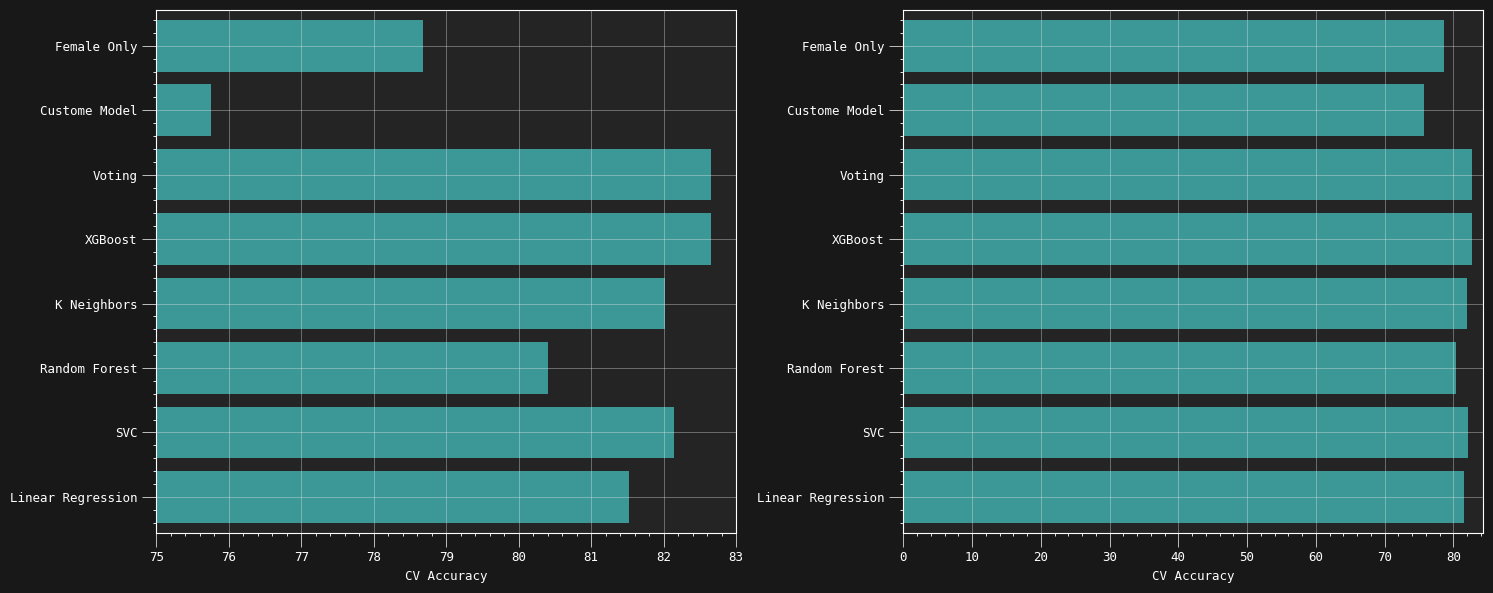

In [41]:
model_scores = [81.52, 82.15, 80.40, 82.02, 82.65, 82.65, 75.7576, 78.68]
model_names = ["Linear Regression", "SVC", "Random Forest", "K Neighbors", "XGBoost", "Voting", "Custome Model", "Female Only"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.barh(model_names, model_scores)
ax1.set_xlabel("CV Accuracy")
ax1.set_xlim((75, 83))

ax2.barh(model_names, model_scores)
ax2.set_xlabel("CV Accuracy")

plt.tight_layout()
plt.show(fig)